In [17]:
import bet.postProcess.compareP as cp
import bet.sampling.basicSampling as bsam
import bet.sample as sample
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as wd
import bet.calculateP.calculateP as calcP
import scipy.spatial.distance as ds


In [18]:
def set_center(num_samples=100,
                   dim=2,
                   delta=0.1, reg=False):
    r"""
    Make unit square domain, create a hyperrectangle with sidelengths
    delta centered around `np.array([[0.5]]*dim)
    """
    s_set = sample.sample_set(dim)
    s_set.set_domain(np.array([[0, 1]]*dim))
    if reg:
        s = bsam.regular_sample_set(s_set, num_samples)
    else:
        s = bsam.random_sample_set('r', s_set, num_samples)
    dd = delta/2.0
    if dim > 1:
        probs = 1*(np.sum(np.logical_and(s._values <= (0.5+dd),
                                     s._values >= (0.5-dd)), axis=1) >= dim-1)
    else:
        probs = 1*(np.logical_and(s._values <= (0.5+dd),
                                     s._values >= (0.5-dd)))
    s.set_probabilities(probs/np.sum(probs))  # uniform probabilities
    s.estimate_volume_mc()
    s.global_to_local()
    return s

def set_zero(num_samples=100,
                   dim=2,
                   delta=0.1, reg=False):
    r"""
    Make unit square domain, create a hyperrectangle with sidelengths
    delta centered around `np.array([[0.5]]*dim)
    """
    s_set = sample.sample_set(dim)
    s_set.set_domain(np.array([[0, 1]]*dim))
    if reg:
        s = bsam.regular_sample_set(s_set, num_samples)
    else:
        s = bsam.random_sample_set('r', s_set, num_samples)    
    dd = delta
    if dim == 1:
        probs = 1*(s._values <= dd)
    else:
        probs = 1*(np.sum(s._values <= dd, axis=1) >= dim-1)
    s.set_probabilities(probs/np.sum(probs))  # uniform probabilities
    s.estimate_volume_mc()
    s.global_to_local()
    return s

def set_one(num_samples=100,
                   dim=2,
                   delta=0.1, reg=False):
    r"""
    Make unit square domain, create a hyperrectangle with sidelengths
    delta centered around `np.array([[0.5]]*dim)
    """
    s_set = sample.sample_set(dim)
    s_set.set_domain(np.array([[0, 1]]*dim))
    if reg:
        s = bsam.regular_sample_set(s_set, num_samples)
    else:
        s = bsam.random_sample_set('r', s_set, num_samples)
    
    dd = delta
    if dim == 1:
        probs = 1*(s._values >= (1-dd))
    else:
        probs = 1*(np.sum(s._values >= (1-dd), axis=1) >= dim-1)
    s.set_probabilities(probs/np.sum(probs))  # uniform probabilities
    s.estimate_volume_mc()
    s.global_to_local()
    return s

def check_densities(s_set, dim=2, delta=0.1, tol=1e-4):
    # density values should be reciprocal of delta^dim
    s = s_set
    dd = delta/2.0
    if dim > 1:
        marks = 1*(np.sum(np.logical_and(s._values <= (0.5+dd),
                                     s._values >= (0.5-dd)), axis=1) >= dim-1)
    else:
        marks = 1*(np.logical_and(s._values <= (0.5+dd),
                                     s._values >= (0.5-dd)))
        
    true_den_val = 1.0/(delta**dim)  
    err = np.mean(np.abs(s_set._den - true_den_val*(marks))) 
    if err < tol:
        return 1
    else:
        return err
    
def answer_sq_hell(dim,d1=0.1,d2=0.2):
    f1 = d1**(-dim)
    f2 = d2**(-dim)
    s1, s2 = np.sqrt(f1), np.sqrt(f2)
    
    single = s2*(d2-d1)
    overlap = d1*(s1-s2)
    return (single + overlap)/2

def answer_tv(dim,d1=0.1,d2=0.2):
    f1 = d1**(-dim)
    f2 = d2**(-dim)
    
    single = f2*(d2-d1)
    overlap = d1*(f1-f2)
    return np.array(single + overlap)/2

In [96]:
dim=1
n=1000
n1=2000
n2=10
delta = 0.3
# s = set_unit_probs(n1, dim, delta)
# r = set_unit_probs(n2, dim, delta)
s = set_zero(n1, dim, delta)
r = set_one(n2, dim, delta)
i = sample.sample_set(dim)
i.set_domain(np.array([[0, 1]]*dim))
I = bsam.random_sample_set('r', i, n)
# i = bsam.regular_sample_set(i, n//10)
m = cp.metrization(I,s,r)
m.estimate_density()
check_densities(s,dim,delta,0.01)

1.436185190311417

## Use `calcP.prob_from_sample_set` to compare

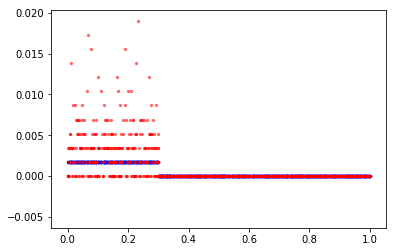

In [97]:
plt.scatter(s._values, s._probabilities, alpha=1,s=5,c='blue')
# plt.scatter(I._values, r._den, alpha=0.25,s=10)

calcP.prob_from_sample_set(s,I)
# I._volumes = s._volumes[m.get_io_ptr_left()]
# I._probabilities /= I._volumes
plt.scatter(I._values, I._probabilities, alpha=0.5, s=5, c='r')
# plt.ylim(0,2)

In [70]:
calcP.prob_from_sample_set??

Signature: calcP.prob_from_sample_set(set_old, set_new)
Source:   
def prob_from_sample_set(set_old, set_new):
    r"""

    Calculates :math:`P_{\Lambda}(\mathcal{V}_{\lambda_{samples_new}})`
    from :math:`P_{\Lambda}(\mathcal{V}_{\lambda_{samples_old}})` using
    the MC assumption with respect to set_old.

    :param set_old: Sample set on which probabilities have already been
        calculated
    :type set_old: :class:`~bet.sample.sample_set_base` 
    :param set_new: Sample set for which probabilities will be calculated.
    :type set_new: :class:`~bet.sample.sample_set_base` 

    """
    # Check dimensions
    set_old.check_num()
    num_new = set_new.check_num()

    if (set_old._dim != set_new._dim):
        raise samp.dim_not_matching("Dimensions of sets are not equal.")

    # Map old points new sets
    if set_old._values_local is None:
        set_old.global_to_local()
    (_, ptr) = set_new.query(set_old._values_local)
    ptr = ptr.flat[:]

    # Set up probability v

In [68]:
np.sum(I._probabilities)

(0, 0.01)

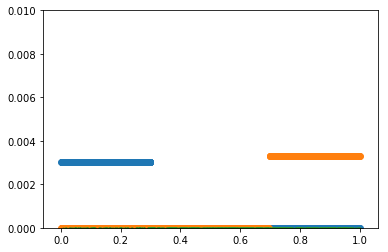

In [6]:
plt.scatter(I._values, s._prob)
plt.scatter(I._values, r._prob)
plt.scatter(I._values, I._probabilities, alpha=0.5,s=2)
plt.ylim(0,0.01)

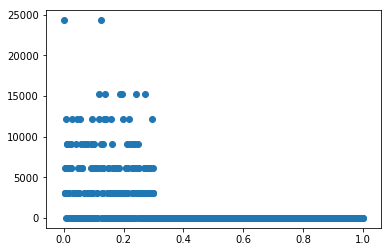

In [7]:
I.estimate_volume_mc()
cp.set_density(I)
plt.scatter(I._values, I._den)

Something strange is happening...

In [8]:
np.sum(I._probabilities)

999.9999999999999

# Testing Meshes and Sample Sizes

In [20]:
def preview1d_reg(n=100, n_mesh=100, n_ref=1000, delta1=0.1, delta2=0.2,
                  c1='r',c2='r',reg_mesh=False, reg_ref=False, dim=1):
    if c1 =='r':
        s = set_one(n_ref, dim, delta1, reg_ref)
    elif c1=='l':
        s = set_zero(n_ref, dim, delta1, reg_ref)
    else:
        s = set_center(n_ref, dim, delta1, reg_ref)
        
    if c2 =='r':
        r = set_one(n_mesh, dim, delta2, reg_mesh)
    elif c2 =='l':
        r = set_zero(n_mesh, dim, delta2, reg_mesh)
    else:
        r = set_center(n_mesh, dim, delta2, reg_mesh)
    np.random.seed(10)
    i = sample.sample_set(dim)
    i.set_domain(np.array([[0, 1]]*dim))
    I = bsam.random_sample_set('r', i, n)
    s = cp.set_density(s)
    r = cp.set_density(r)
    mm = cp.metrization(I,s,r)
    mm.estimate_density()
    
#     print(check_densities(s,dim,delta1,0.05))
#     print(check_densities(r,dim,delta2,0.05))
    
    if dim == 1:
        plt.scatter(I._values, s._den)
        plt.scatter(I._values, r._den)
        plt.ylim(0,15)
        plt.hlines(5,0,1)
        plt.hlines(10,0,1)
    print(mm.distance(),mm.distance('sqhell'))
#     print(answer_tv(dim,delta1,delta2),
#           answer_sq_hell(dim,delta1,delta2))
#     print(0.5*np.sum(np.abs(mm._den_left - mm._den_right))/I.check_num())
wd.interact(preview1d_reg, 
            n=wd.IntSlider(500,100,10000,step=100, continuous_update=False),
            n_ref=wd.IntSlider(500,100,10000,step=100, continuous_update=False),
            n_mesh=wd.IntSlider(500,100,10000,step=100, continuous_update=False),
            delta1=wd.FloatSlider(0.1,min=0.1,max=.75,step=0.05),
            delta2=wd.FloatSlider(0.1,min=0.1,max=.75,step=0.05),
            c1=wd.Dropdown(options=['c','r','l']), c2=wd.Dropdown(options=['c','r','l']),
            reg_ref=wd.Checkbox(description="Regular Ref"),
            reg_mesh=wd.Checkbox(description="Regular Mesh"),
            dim=wd.IntSlider(1,1,5)
           )

interactive(children=(IntSlider(value=500, continuous_update=False, description='n', max=10000, min=100, step=…

<function __main__.preview1d_reg(n=100, n_mesh=100, n_ref=1000, delta1=0.1, delta2=0.2, c1='r', c2='r', reg_mesh=False, reg_ref=False, dim=1)>

# Convergence Study

In [51]:
nvals

[40, 80, 160, 320, 640, 1280, 2560]

In [56]:
n_l, n_r = 20, 1000
n = 1000
dim = 1
delta1, delta2 = 0.4, 0.5 # order so d1 < d2
num_trials = 10
nvals = [10*2**N for N in range(2,9)]
hl = np.zeros((num_trials, len(nvals))) # data storage
tl = np.zeros((num_trials, len(nvals)))

i = sample.sample_set(dim)
i.set_domain(np.array([[0, 1]]*dim))
I = bsam.random_sample_set('r', i, n)
# I = bsam.regular_sample_set(i, 10)

s = set_center(n_l, dim, delta1, reg=True)
r = set_center(n_r, dim, delta2, reg=False)
m = cp.metrization(I,s,r)
m.set_io_ptr_left()
m.set_io_ptr_right()

for t in range(num_trials):
    hh = [] # temporary vectors
    tv = []
    #     np.random.seed(t)
    for n in nvals:
        # effect of MC integration error
#         m.set_int(bsam.random_sample_set('r', i, n))
#         m.set_io_ptr_left()
#         m.set_io_ptr_right()
        
        # random sampling error relative to reference solution.
        r = set_center(n, dim, delta2, reg=False)
        m.set_right(r)
        m.set_io_ptr_right()
        
        m.estimate_density()
        hh.append(m.distance('sqhell'))
        tv.append(m.distance('tv'))
    hl[t,:] = np.array(hh) # averaging, cumulative sum.
    tl[t,:] = np.array(tv)
h = np.mean(hl, axis=0)
t = np.mean(tl, axis=0)

In [58]:
np.var(hl-2*answer_sq_hell(dim,delta1,delta2), axis=0)

array([6.16814504e-04, 8.95212116e-05, 5.08937509e-05, 1.30019269e-05,
       3.63846784e-06, 3.97190870e-06, 3.24105675e-07])

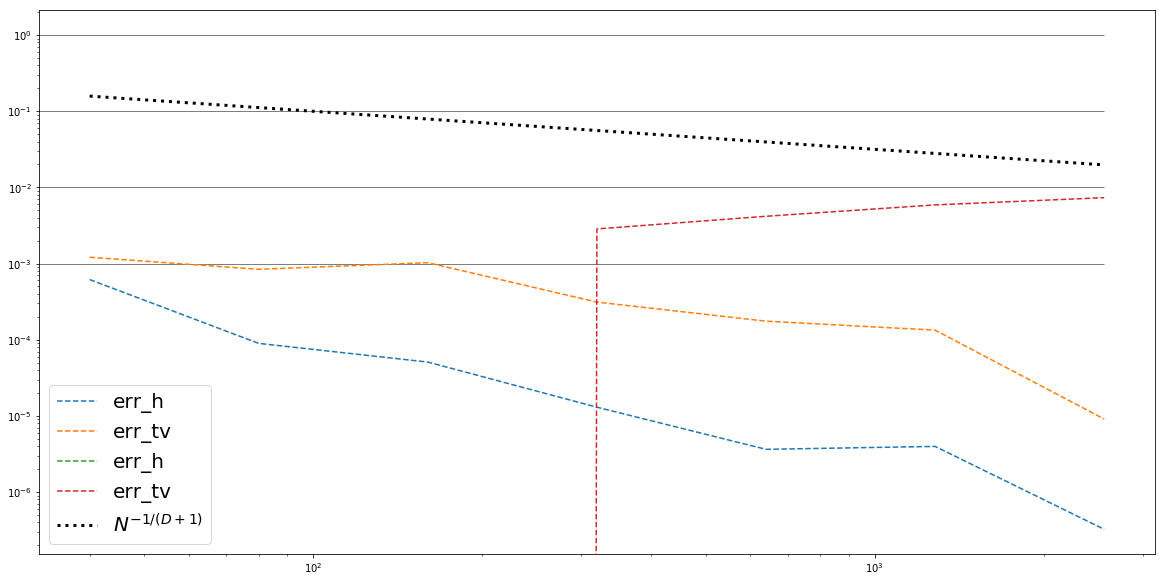

In [64]:
plt.figure(figsize=(20,10))
if delta1 == delta2:
    plt.plot(nvals, t, label='tv',lw=10,c='r')
    plt.plot(nvals, h, label='sq',lw=3,c='b',alpha=0.5)
else:
    plt.plot(nvals, np.var(hl-2*answer_sq_hell(dim,delta1,delta2), axis=0), ls = '--', label='err_h')
    plt.plot(nvals, np.var(tl-answer_tv(dim, delta1, delta2), axis=0), ls = '--', label='err_tv')
    plt.plot(nvals, np.mean(hl-2*answer_sq_hell(dim,delta1,delta2), axis=0), ls = '--', label='err_h')
    plt.plot(nvals, np.mean(tl-answer_tv(dim, delta1, delta2), axis=0), ls = '--', label='err_tv')
    
    # plt.plot(nvals, np.abs(hh-answer_tv(dim, delta1, delta2)))
    plt.plot(nvals, np.power(np.array(nvals,dtype=float),-1./2), lw=3, ls=':', label='${N}^{-1/(D+1)}$', c='k')
    
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=20)
# plt.ylim(1E-4,1)
for k in range(4):
    plt.hlines(10**(-k),0,nvals[-1], lw=1,alpha=0.5)

In [12]:
m.get_right(), r.check_num()

(<bet.sample.sample_set at 0x7fd7f2ea4da0>, 1280)

In [13]:
h,answer_sq_hell(dim,delta1,delta2)

(array([0.59802187, 0.45980518, 0.36133259, 0.30747701, 0.25778628,
        0.19065534]), 0.0)

In [14]:
t, answer_tv(dim, delta1, delta2)

(array([0.64491685, 0.507621  , 0.40373304, 0.32979428, 0.29014545,
        0.20300601]), 0.0)

In [15]:
h[1:]/h[:-1]

array([0.76887686, 0.78583844, 0.85095291, 0.83839204, 0.73958684])

In [16]:
t[1:]/t[:-1]

array([0.78711077, 0.79534346, 0.81686224, 0.8797771 , 0.6996698 ])